In [4]:
import numpy as np
from skimage import io, draw, color, morphology, data
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
lower_threshold_cd4 = 10;
upper_threshold_cd4 = 255;
lower_threshold_cd8 = 10;
upper_threshold_cd8 = 255;
lower_threshold_insulin = 10;
upper_threshold_insulin = 255;
lower_threshold_glucagon = 10;
upper_threshold_glucagon = 255;
islet_outlier_size = 5;

def _scale_region(image, region):
    polygon = np.array(region)
    polygon[:,0] = polygon[: ,0] * image.shape[0]
    polygon[:,1] = polygon[: ,1] * image.shape[1]
    return polygon

def _mask_image(image, region):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    polygon = _scale_region(image, region)
    rr, cc = draw.polygon(polygon[:, 1], polygon[:, 0], mask.shape)
    mask[rr, cc] = 255
    masked_image = image.copy()
    masked_image[mask == 0] = 0
    return masked_image

def _compute_masked_image_stats(masked_image):
    pixels = masked_image.reshape(image.shape[0] * image.shape[1], 3)
    ix = np.nonzero(np.any(pixels, axis=1))[0]
    return pixels[ix].mean(axis=0), pixels[ix].std(axis=0)

def _compute_subtraction_value(means, stds):
    return means + 3 * stds

def subtract_background(image, region):
    masked_image = _mask_image(image, region)
    means, stds = _compute_masked_image_stats(masked_image)
    subtraction_value = _compute_subtraction_value(means, stds)
    modified_image = image - subtraction_value
    return np.clip(modified_image, 0, 255).astype(np.uint8)

def save_image(name, image):
    io.imsave(name, image)

def convert_to_mask(image, lower_threshold, upper_threshold):
    image[image < lower_threshold] = 0
    mask = color.rgb2gray(image)
    return mask > 0

def combine_images(image1, image2):
    combined_image = np.logical_or(image1, image2)
    return combined_image

def remove_small_objects_and_holes(image):
    object_size = islet_outlier_size = (5**5) * 3.14
    cleaned_image = morphology.remove_small_objects(image, object_size)
    cleaned_image = morphology.remove_small_holes(cleaned_image, object_size * 4)
    return cleaned_image

def create_insulin_glucagon_mask(insulin_image, glucagon_image):
    masked_insulin = convert_to_mask(insulin_image, lower_threshold_insulin, upper_threshold_insulin)
    masked_glucagon = convert_to_mask(glucagon_image, lower_threshold_glucagon, upper_threshold_glucagon)
    combined_mask = combine_images(masked_insulin, masked_glucagon)
    cleaned_mask = remove_small_objects_and_holes(combined_mask)
    return cleaned_mask

/opt/anaconda3/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


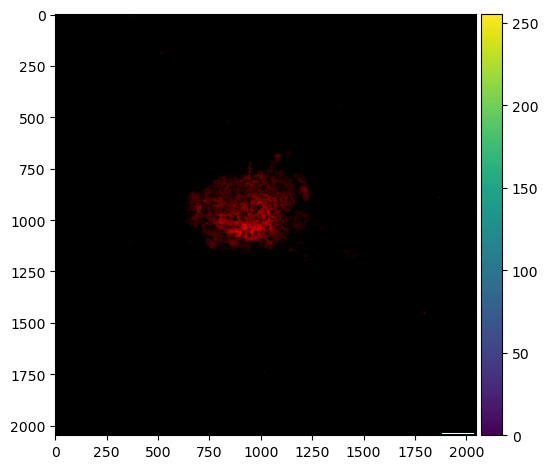

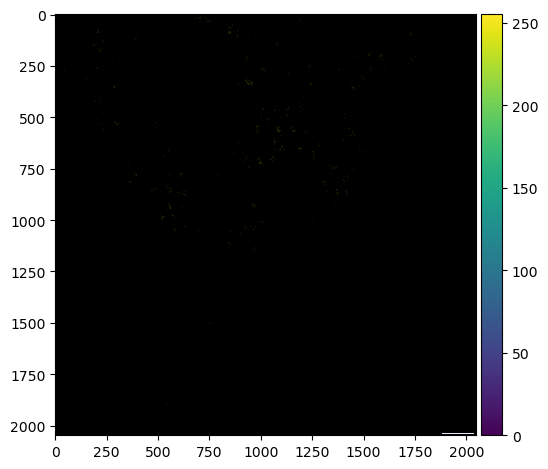

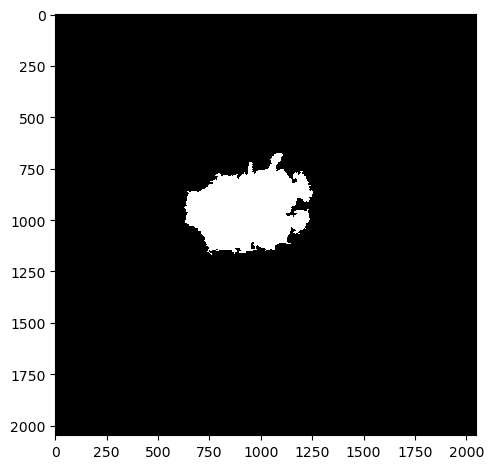

In [6]:
insulin = io.imread('test_images/Image001_ch02_SV_bg_correct.png')
glucagon = io.imread('test_images/Image001_ch03_SV_bg_correct.png')

mask = create_insulin_glucagon_mask(insulin, glucagon)
io.imshow(insulin)
io.show()
io.imshow(glucagon)
io.show()
io.imshow(mask)
io.show()
